# Assignment 1
# Sparse Bayesian Neural Networks using Automatic Relevance Determination

Variational Dropout ([arXiv:1506.02557](https://arxiv.org/abs/1506.02557)) provides a Bayesian interpretation of the conventional dropout procedure. Later it was shown that Variational Dropout can be used for model sparsification (Sparse VD), an the effect can be achieved via optimization of variational lower bound wrt individual dropout rates for every weight of the model ([arXiv:1701.05369](https://arxiv.org/abs/1701.05369)).

In this assignment we would consider another interpretation of this model that uses the *Automatic Relevance Determination* (ARD) prior. This model is described in [arXiv:1811.00596](https://arxiv.org/abs/1811.00596).

#### ARD BNN

The ARD BNN model optimizes the evidence lower bound (ELBO) $\mathcal{L}(\phi)$ with respect to parameters $\phi$ of a variational approximation $q_\phi(w)$:

$$\mathcal{L}(\phi) =  L_\mathcal{D}(\phi) - D_{KL}(q_\phi(w)\,\|\,p(w\,|\,\lambda^2)) \to\max_{\phi, \lambda^2},$$
$$L_\mathcal{D}(\phi) = \sum_{n=1}^N \mathrm{E}_{q_\phi(w)}[\log p(y_n\,|\,x_n, w)],$$
$$p(w_{ij}\,|\,\lambda^2_{ij})=\mathcal{N}(w_{ij}\,|\,0,\lambda^2_{ij})\text{ is the ARD prior,}$$

$$q_\phi(w_{ij}) = \mathcal{N}(w_{ij}\,|\,\mu_{ij},\sigma^2_{ij})\text{ is the fully-factorized Gaussian posterior approximation},$$

and the log-likelihood $p(y\,|\,x, w)$ is defined by a neural network with parametrs $w$ using a conventional cross-entropy loss function. The optimization is performed by stochasic optimization methods. Adam with default hyperparameters and a simple multi step LR schedule should work fine.

The optimization w.r.t. the prior variance $\lambda^2$ can be performed analytically; the optimal value is $\lambda_{ij}^2=\mu_{ij}^2+\sigma_{ij}^2$. The KL-divergence term then becomes equal to:

$$D_{KL}(q_\phi(w)\,\|\,p(w\,|\,\lambda^2))=\frac{1}{2}\sum_{ij}\log(1+\frac{\mu_{ij}^2}{\sigma_{ij}^2}).$$

**Note:** You will need to refer to the value $\log\alpha_{ij}=\log\frac{\sigma_{ij}^2}{\mu_{ij}^2}$ in order to determine which weights to zero out. It is also convenient to use it to compute the KL divergence. A rule of thumb is to zero out all the weights that have $\log\alpha_{ij}>3$, but you can use another threshold.

**Note:** Optimize w.r.t. $\log\sigma$ instead of $\sigma$ to better represent small values of $\sigma$.

**Note:** Some of the operations (e.g. log and square root) can be unstable for small arguments. In order to avoid NaNs, you can add a "safe" modification: just add a small constant (e.g. `1e-8`) to the argument and / or use appropriate clamping.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/bd8c169c6b162dac5aa77013d70463eae0927c5e/images/svd3.png)


# In this assignment:
1. Implementation of fully-connected ARD Layer
2. Training Lenet-300-100 on MNIST dataset
3. Optional Research Assignment

Additional information:
- If you have a problem with importing logger, download logger.py and file to the same folder and run a notebook from it
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib), tabulate
- If you have an urgent question or find a typo or a mistake, text it to Alexander Grishin in Discord

In [1]:
import math
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch.distributions import Normal
from torchvision import datasets, transforms

from logger import Logger

## Implementation of  the Linear ARD layer

In [2]:
EPSILON = 1e-8

class LinearARD(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearARD, self).__init__()
        """
            in_features: int, a number of input features
            out_features: int, a number of neurons
            threshold: float, a threshold for clipping weights
        """
        
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        self.mu = Parameter(torch.empty(out_features, in_features))
        self.log_sigma = Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.empty(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        if self.bias is not None:
            self.bias.data.zero_()
        self.mu.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)        
        
    def forward(self, x, threshold=None):     
        # x is a torch.Tensor of shape (number_of_objects, in_features)
        
        # log_alpha is a torch.Tensor of shape (out_features, in_features)
        self.log_alpha = 2 * (self.log_sigma - torch.log(torch.abs(self.mu) + EPSILON))
        
        # clipping for a numerical stability
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10)   
        
        if self.training:
            # LRT = local reparametrization trick
            
            # lrt_mean is a torch.Tensor of shape (x.shape[0], out_features)
            lrt_mean = F.linear(x, self.mu) # compute mean activation using LRT; you can use F.linear
            
            sigma = torch.exp(self.log_sigma)
            lrt_var = F.linear(x**2, sigma**2)
            
            # lrt_std is a torch.Tensor of shape (x.shape[0], out_features)
            lrt_std = torch.sqrt(lrt_var + EPSILON) # compute std of activations unsig lrt; you can use F.linear
            
            norm = Normal(loc=lrt_mean, scale=lrt_std)
            reparametrized_sample = norm.rsample()
            activation_sample = reparametrized_sample + (self.bias if self.bias is not None else 0)
            return activation_sample # sample of activation
        
        threshold = threshold or self.threshold
        zero = torch.zeros(1, device=self.mu.device)
        # clip all weight with log_alpha > threshold
        weights = torch.where(self.log_alpha > threshold, zero, self.mu)
        out = F.linear(x, weights, self.bias)
        return out
        
    def kl_reg(self):
        # kl is a scalar torch.Tensor 
        kl = 0.5 * torch.sum(torch.log1p(torch.exp(-self.log_alpha))) # eval the KL divergence
        return kl

## Define LeNet-300-100

In [3]:
class Net(nn.Module):
    def __init__(self, threshold, Layer=LinearARD):
        super(Net, self).__init__()
        self.fc1 = Layer(28*28, 300, threshold)
        self.fc2 = Layer(300,  100, threshold)
        self.fc3 = Layer(100,  10, threshold)
        self.threshold=threshold

    def forward(self, x, threshold=None):
        x = F.relu(self.fc1(x, threshold))
        x = F.relu(self.fc2(x, threshold))
        x = F.log_softmax(self.fc3(x, threshold), dim=1)
        return x

## Function for loading MNIST

In [4]:
def get_mnist(batch_size, path='./data'):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(path, train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(path, train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

## Define the ELBO loss function

In [5]:
class ELBO(nn.Module):
    def __init__(self, net, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size # int, the len of dataset
        self.net = net # nn.Module
        
    def forward(self, input, target, kl_weight=1.0):
        """
          input: is a torch.Tensor (a predictions of the model) 
          target: is a torch.Tensor (a tensor of labels) 
        """
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        
        neg_log_likelihood = self.train_size * F.nll_loss(input, target, reduction='mean')
        elbo_loss = neg_log_likelihood + kl_weight * kl # a scalar torch.Tensor, ELBO loss
        return elbo_loss

## Define the model

In [6]:
model = Net(threshold=3)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

logger = Logger('ard', fmt={
    'tr_loss': '3.2e',
    'te_loss': '3.2e',
    'sp_0':    '.3f',
    'sp_1':    '.3f',
    'sp_2':    '.3f',
    'lr':      '3.1e',
    'kl':      '.2f',
    'time':    '.2f',
})

train_loader, test_loader = get_mnist(batch_size=300)
elbo = ELBO(model, len(train_loader.dataset))

## Train the model

In [7]:
# Switch the device to cuda to reduce one epoch from ~30 sec to ~10 sec

# device = 'cpu'
device = 'cuda:0'

def eval_model(model, elbo, test_loader, kl_weight, threshold=None, device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            data = data.view(-1, 28*28)
            output = model(data, threshold)
            test_loss += float(elbo(output, target, kl_weight))
            pred = output.data.max(1)[1] 
            test_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset) * 100
    return test_loss, test_acc

In [8]:
def train(model, elbo, optimizer, scheduler, logger,
          train_loader, test_loader,
          epochs=100, init_kl_weight=0., delta_kl_weight=0.03, device=device):
    model = model.to(device)
    elbo = elbo.to(device)
    kl_weight = init_kl_weight
    for epoch in range(1, epochs + 1):
        time_start = time.perf_counter()
        model.train()
        train_loss, train_acc = 0, 0 
        kl_weight = min(kl_weight+delta_kl_weight, 1)
        logger.add_scalar(epoch, 'kl', kl_weight)
        logger.add_scalar(epoch, 'lr', scheduler.get_last_lr()[0])
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            data = data.view(-1, 28*28)
            optimizer.zero_grad()

            output = model(data)
            pred = output.data.max(1)[1] 
            loss = elbo(output, target, kl_weight)
            loss.backward()
            optimizer.step()

            train_loss += float(loss) 
            train_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())

        scheduler.step()
        logger.add_scalar(epoch, 'tr_loss', train_loss / len(train_loader.dataset))
        logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)

        test_loss, test_acc = eval_model(model, elbo, test_loader, kl_weight, device=device)
        logger.add_scalar(epoch, 'te_loss', test_loss)
        logger.add_scalar(epoch, 'te_acc', test_acc)

        for i, c in enumerate(model.children()):
            if hasattr(c, 'kl_reg'):
                logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.data.cpu().numpy() > model.threshold).mean())

        logger.add_scalar(epoch, 'time', time.perf_counter() - time_start)
        logger.iter_info()

In [9]:
train(model, elbo, optimizer, scheduler, logger,
        train_loader, test_loader)

  epoch    kl       lr    tr_loss    tr_acc    te_loss    te_acc    sp_0    sp_1    sp_2    time
-------  ----  -------  ---------  --------  ---------  --------  ------  ------  ------  ------
      1  0.03  5.0e-04   1.38e+02      84.9   7.37e+01      92.1   0.224   0.064   0.037   13.00
      2  0.06  4.7e-04   8.07e+01      93.1   6.70e+01      94.5   0.450   0.091   0.042   12.60
      3  0.09  4.5e-04   7.19e+01      94.9   6.22e+01      95.7   0.589   0.138   0.029   12.57
      4  0.12  4.3e-04   6.62e+01      95.9   6.04e+01      96.1   0.684   0.222   0.033   12.45
      5  0.15  4.1e-04   6.22e+01      96.4   5.89e+01      96.5   0.744   0.307   0.042   12.45
      6  0.18  3.9e-04   5.91e+01      96.8   5.61e+01      96.9   0.787   0.389   0.048   12.46
      7  0.21  3.7e-04   5.66e+01      97.1   5.40e+01      97.0   0.818   0.460   0.049   12.46
      8  0.24  3.5e-04   5.45e+01      97.3   5.28e+01      97.2   0.843   0.521   0.056   12.47
      9  0.27  3.3e-04   5.26e

     84     1  7.1e-06   3.95e+01      98.0   4.06e+01      97.8   0.973   0.916   0.342   12.50
     85     1  6.7e-06   3.93e+01      98.0   4.05e+01      97.8   0.973   0.916   0.343   13.06
     86     1  6.4e-06   3.93e+01      98.0   4.06e+01      97.8   0.973   0.916   0.343   12.82
     87     1  6.1e-06   3.93e+01      97.9   4.07e+01      97.7   0.973   0.916   0.344   12.63
     88     1  5.8e-06   3.94e+01      97.9   4.04e+01      97.7   0.973   0.916   0.344   12.40
     89     1  5.5e-06   3.95e+01      98.0   4.07e+01      97.7   0.973   0.916   0.344   12.39
     90     1  5.2e-06   3.94e+01      97.9   4.04e+01      97.7   0.973   0.916   0.344   12.38
     91     1  4.9e-06   3.94e+01      98.0   4.09e+01      97.7   0.973   0.916   0.344   12.94
     92     1  4.7e-06   3.93e+01      97.9   4.06e+01      97.7   0.973   0.916   0.344   12.97
     93     1  4.5e-06   3.93e+01      98.0   4.06e+01      97.7   0.973   0.916   0.344   12.63
     94     1  4.2e-06   3.91e

In [11]:
def get_compression_ratio(model, threshold=None):
    threshold = threshold or model.threshold
    all_w, kep_w = 0, 0

    for c in model.children():
        kep_w += (c.log_alpha.data.cpu().numpy() < threshold).sum()
        all_w += c.log_alpha.data.cpu().numpy().size
    return all_w/kep_w

# compression_ratio should be > 25
compression_ratio = get_compression_ratio(model)
print('compression_ratio =', compression_ratio)
assert compression_ratio >= 25

compression_ratio = 28.286048241419614


## Disk space

In [12]:
import scipy
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
from os.path import join
from os import makedirs, name as os_name

def save_weights(model, weights_dir, threshold=None):
    threshold = threshold or model.threshold
    row, col, data = [], [], []
    M = list(model.children())[0].mu.data.cpu().numpy()
    LA = list(model.children())[0].log_alpha.data.cpu().numpy()

    for i in range(300):
        for j in range(28*28):
            if LA[i, j] < threshold:
                row += [i]
                col += [j]
                data += [M[i, j]]

    Mcsr = csr_matrix((data, (row, col)), shape=(300, 28*28))
    Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
    Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))
    
    makedirs(weights_dir, exist_ok=True)
    np.savez_compressed(join(weights_dir, 'M_w'), M)
    scipy.sparse.save_npz(join(weights_dir, 'Mcsr_w'), Mcsr)
    scipy.sparse.save_npz(join(weights_dir, 'Mcsc_w'), Mcsc)
    scipy.sparse.save_npz(join(weights_dir, 'Mcoo_w'), Mcoo)

def show_files(directory, regexp='.npz'):
    command_prefix = 'wsl' if os_name == 'nt' else ''
    ! $command_prefix ls -lah $directory | $command_prefix grep $regexp

In [13]:
weights_dir = './weights/'
save_weights(model, weights_dir)
show_files(weights_dir)

-rwxr-xr-x 1 root root  32K окт 28 15:27 Mcoo_w.npz
-rwxr-xr-x 1 root root  31K окт 28 15:27 Mcsc_w.npz
-rwxr-xr-x 1 root root  31K окт 28 15:27 Mcsr_w.npz
-rwxr-xr-x 1 root root 843K окт 28 15:27 M_w.npz


## Visualization

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 4
rcParams['figure.dpi'] = 200

def plot_weights(layer, threshold=None):
    threshold = threshold or layer.threshold
    mask = (layer.log_alpha.detach().cpu().numpy() < threshold).astype(np.float)
    W = layer.mu.detach().cpu().numpy()

    # Normalize color map
    max_val = np.max(np.abs(mask * W))
    norm = mpl.colors.Normalize(vmin=-max_val,vmax=max_val)
    plt.figure(figsize=(24, 16))
    plt.imshow(mask * W, cmap='RdBu', interpolation=None, norm=norm)
    plt.colorbar()

In [15]:
def plot_neurons(layer, threshold=None):
    threshold = threshold or layer.threshold
    mask = (layer.log_alpha.detach().cpu().numpy() < threshold).astype(np.float)
    W = layer.mu.detach().cpu().numpy()
    
    s = 0
    z = np.zeros((28*15, 28*15))

    for i in range(15):
        for j in range(15):
            s += 1
            z[i*28:(i+1)*28, j*28:(j+1)*28] = np.abs((mask * W)[s].reshape(28, 28))

    plt.figure(figsize=(24, 16))
    plt.imshow(z, cmap='hot_r')
    plt.colorbar()
    plt.axis('off')

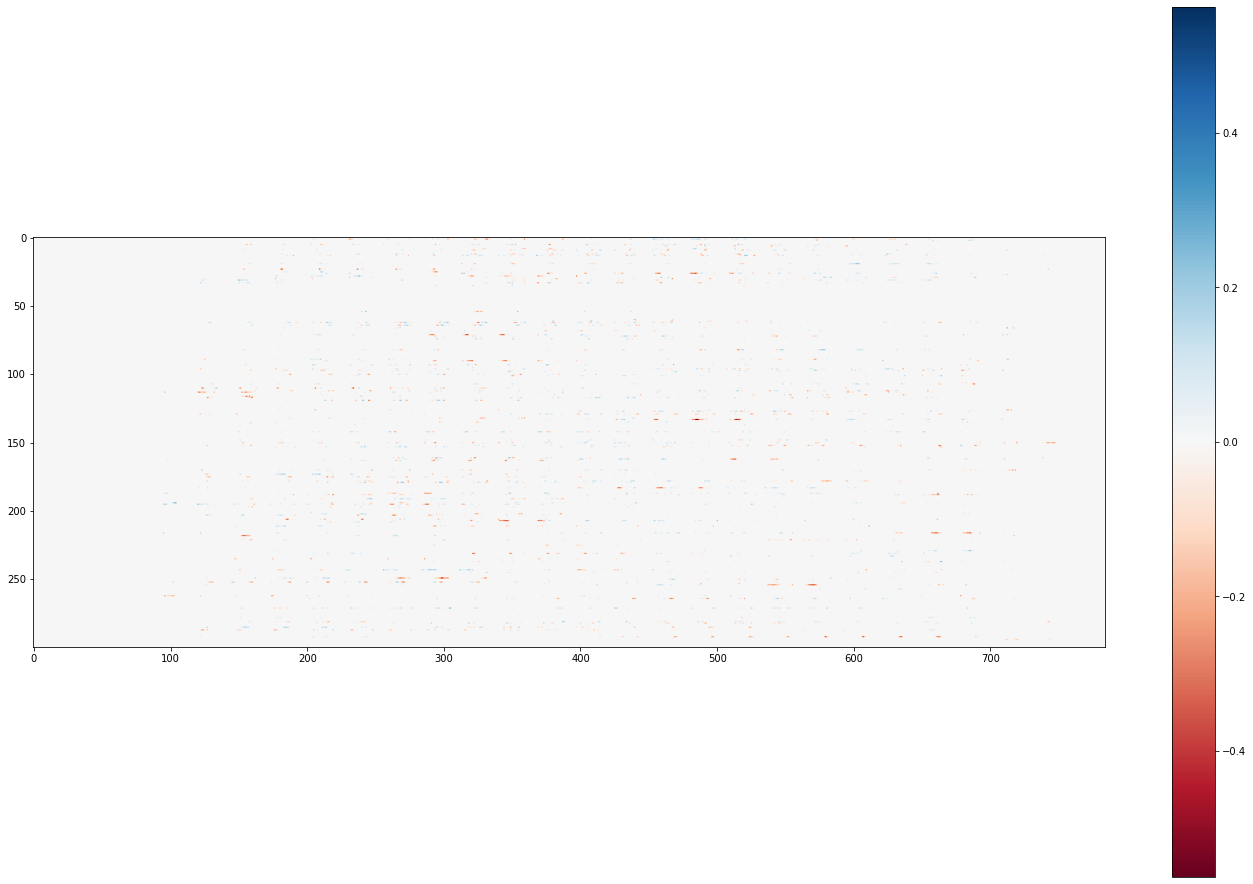

In [16]:
plot_weights(model.fc1)

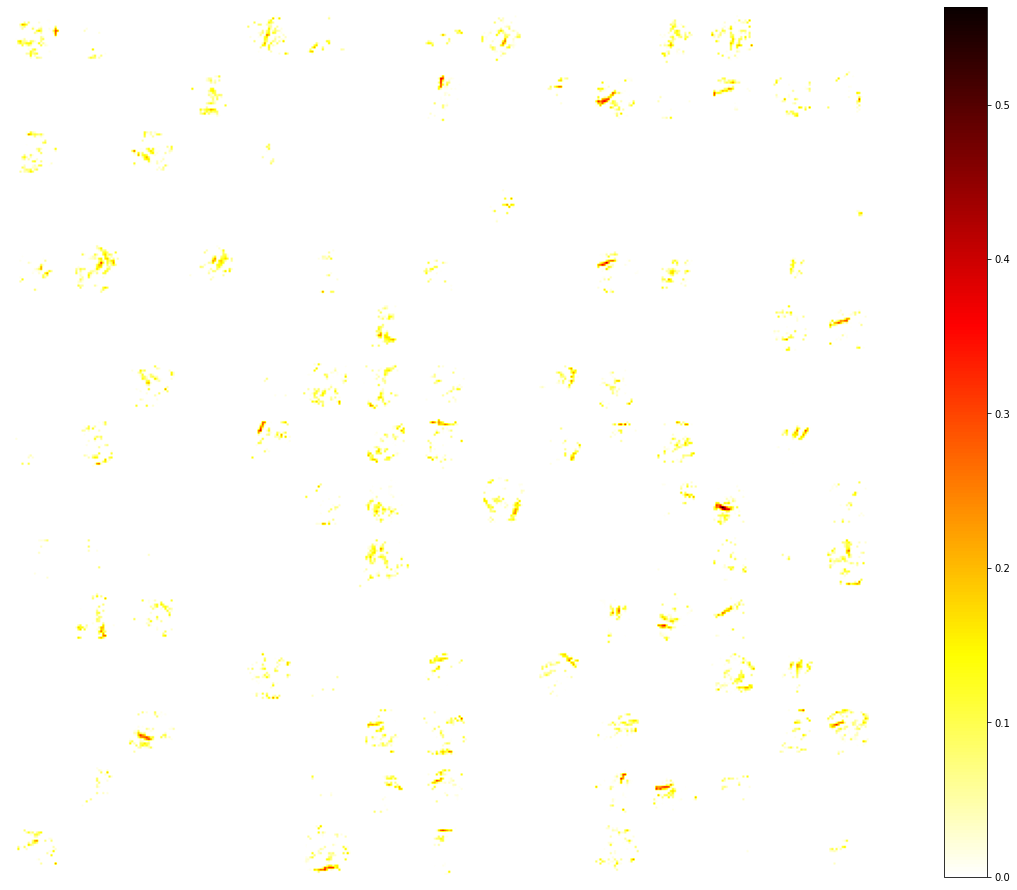

In [17]:
plot_neurons(model.fc1)

# Optional Research Assignment (up to 2 additional points)

1. Study the model: 
    - How sparsity and accuracy depend on maximum of KL-multiplier (kl_weight)?
    - How sparsity and accuracy depend on the initialization?
    - Study the KL: what if we optimize w.r.t. $\lambda^2$ using Adam instead of substituting the optimal $\lambda^2$?
    - How does the behaviour of optimization change if you use another parameterization for the approximate posterior? How does it affect the variance of the stochastic gradients?
2. Compression:
    - What can we do to obtain better compression results with small quality degradation?
    - Propose and eval several options.
3. Study the Local reparametrization trick: 
    - Does it really accelerate convergence?
    - Does variance of gradient decrease?
    
You can do one out of three parts. You need to provide evidence for results e.g., plots, etc.

## Let's try to improve compression results
### 1. Changing threshold
The easiest way to do it is to just set a lower value for `threshold` parameter of the model. Let's try different threshold values from 0.1 to 3 and evaluate compression ratio as well as test accuracy and test loss.

In [18]:
from tqdm import tqdm
import pandas as pd

metrics = []

for t in tqdm(np.linspace(0.1, 3, 30)):
    cr = get_compression_ratio(model, threshold=t)
    test_loss, test_acc = eval_model(model, elbo, test_loader, kl_weight=1, threshold=t)
    metrics.append(dict(threshold=t, compression_ratio=cr, test_loss=test_loss, test_acc=test_acc))
metrics = pd.DataFrame.from_records(metrics)

100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


In [19]:
metrics

,threshold,compression_ratio,test_loss,test_acc
0,0.1,42.361553,41.585461,97.54
1,0.2,41.697995,42.239985,97.52
2,0.3,41.099274,41.392067,97.54
3,0.4,40.474380,41.346721,97.55
4,0.5,40.018040,41.460872,97.58
5,0.6,39.530740,41.433076,97.60
6,0.7,39.141303,41.351794,97.58
7,0.8,38.669378,41.325762,97.57
8,0.9,38.236139,41.082268,97.58
9,1.0,37.850135,41.294656,97.61


We can increase the compression ratio from 28 to 31 without degrading the test accuracy.  
We also can get compression ratio of 42 at the cost of dropping the accuracy from 97.75% to 97.54%.

### 2. Changing ARD prior
Let's change the original ARD prior from  
$$p(w_{ij}\,|\,\lambda^2_{ij})=\mathcal{N}(w_{ij}\,|\,0,\lambda^2_{ij})$$  
to  
$$p(w_{ij}\,|\,\lambda^2_{i})=\mathcal{N}(w_{ij}\,|\,0,\lambda^2_{i})$$  
to zero out entire rows of weight matrices.  

New optimal prior variance $\lambda^2$ is now $\lambda_{i}^2 = \frac{1}{d_{in}} \sum_{j=1}^{d_{in}}(\mu_{ij}^2+\sigma_{ij}^2)$. 

The KL-divergence term then becomes equal to:  
$$D_{KL}(q_\phi(w)\,\|\,p(w\,|\,\lambda^2))=\sum_{ij}\bigg[ \frac{1}{2}\log\frac{\lambda_{i}^2}{\sigma_{ij}^2} + \frac{\sigma_{ij}^2 + \mu_{ij}^2}{2\lambda_i^2} \bigg] = \frac{d_{in}}{2}\sum_{i=1}^{d_{out}}\log \lambda_i^2 - \sum_{i,j}\log\sigma_{ij} + \frac{d_{in}d_{out}}{4}.$$

In [20]:
class RDLinearARD(LinearARD):
    """Row Dropout LinearARD"""
    
    def kl_reg(self):
        sigma2 = torch.exp(2*self.log_sigma)
        mu2 = self.mu ** 2
        lambda2 = torch.mean(mu2 + sigma2, dim=1)
        assert lambda2.shape == (self.out_features,)
        log_lambda2 = torch.log(lambda2 + EPSILON)
        kl = (0.5 * self.in_features * torch.sum(log_lambda2)
              - torch.sum(self.log_sigma)
              + 0.25 * self.in_features * self.out_features)
        return kl

In [21]:
rd_model = Net(threshold=3, Layer=RDLinearARD)
optimizer = optim.Adam(rd_model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

logger = Logger('rd_ard', fmt={
    'tr_loss': '3.1e',
    'te_loss': '3.1e',
    'sp_0':    '.3f',
    'sp_1':    '.3f',
    'sp_2':    '.3f',
    'lr':      '3.1e',
    'kl':      '.2f',
    'time':    '.2f',
})

train_loader, test_loader = get_mnist(batch_size=300)
elbo = ELBO(rd_model, len(train_loader.dataset))

In [22]:
train(rd_model, elbo, optimizer, scheduler, logger,
        train_loader, test_loader)

  epoch    kl       lr    tr_loss    tr_acc    te_loss    te_acc    sp_0    sp_1    sp_2    time
-------  ----  -------  ---------  --------  ---------  --------  ------  ------  ------  ------
      1  0.03  5.0e-04    1.6e+02      84.3    9.2e+01      92.3   0.073   0.050   0.027   13.05
      2  0.06  4.7e-04    1.1e+02      93.1    1.0e+02      94.6   0.134   0.049   0.016   12.91
      3  0.09  4.5e-04    1.1e+02      94.8    9.8e+01      95.6   0.315   0.052   0.016   12.98
      4  0.12  4.3e-04    1.1e+02      95.4    1.0e+02      95.7   0.456   0.058   0.011   12.81
      5  0.15  4.1e-04    1.1e+02      95.9    1.1e+02      96.4   0.568   0.064   0.012   12.92
      6  0.18  3.9e-04    1.2e+02      96.2    1.1e+02      96.3   0.661   0.075   0.013   12.89
      7  0.21  3.7e-04    1.2e+02      96.3    1.2e+02      96.1   0.724   0.093   0.016   12.98
      8  0.24  3.5e-04    1.3e+02      96.5    1.3e+02      96.5   0.760   0.123   0.017   13.02
      9  0.27  3.3e-04    1.3e

     84     1  7.1e-06    2.9e+02      95.8    2.9e+02      96.8   0.946   0.894   0.033   12.78
     85     1  6.7e-06    2.9e+02      95.8    2.9e+02      96.8   0.946   0.894   0.033   12.76
     86     1  6.4e-06    2.9e+02      95.8    2.9e+02      96.8   0.946   0.894   0.033   12.92
     87     1  6.1e-06    2.9e+02      95.8    2.9e+02      96.8   0.946   0.894   0.033   12.72
     88     1  5.8e-06    2.9e+02      95.8    2.9e+02      96.8   0.946   0.894   0.033   12.68
     89     1  5.5e-06    2.9e+02      95.7    2.9e+02      96.8   0.946   0.894   0.033   12.59
     90     1  5.2e-06    2.9e+02      95.8    2.9e+02      96.8   0.946   0.894   0.033   13.02
     91     1  4.9e-06    2.9e+02      95.9    2.9e+02      96.8   0.946   0.894   0.032   12.67
     92     1  4.7e-06    2.9e+02      95.7    2.9e+02      96.8   0.946   0.895   0.033   12.71
     93     1  4.5e-06    2.9e+02      95.8    2.9e+02      96.8   0.946   0.894   0.032   12.66
     94     1  4.2e-06    2.9e

In [23]:
compression_ratio = get_compression_ratio(rd_model)
print('compression_ratio =', compression_ratio)

compression_ratio = 15.924862407274468


In [24]:
weights_dir = './rd_weights/'
save_weights(rd_model, weights_dir)
show_files(weights_dir)

-rwxr-xr-x 1 root root  54K окт 28 15:49 Mcoo_w.npz
-rwxr-xr-x 1 root root  52K окт 28 15:49 Mcsc_w.npz
-rwxr-xr-x 1 root root  54K окт 28 15:49 Mcsr_w.npz
-rwxr-xr-x 1 root root 785K окт 28 15:49 M_w.npz


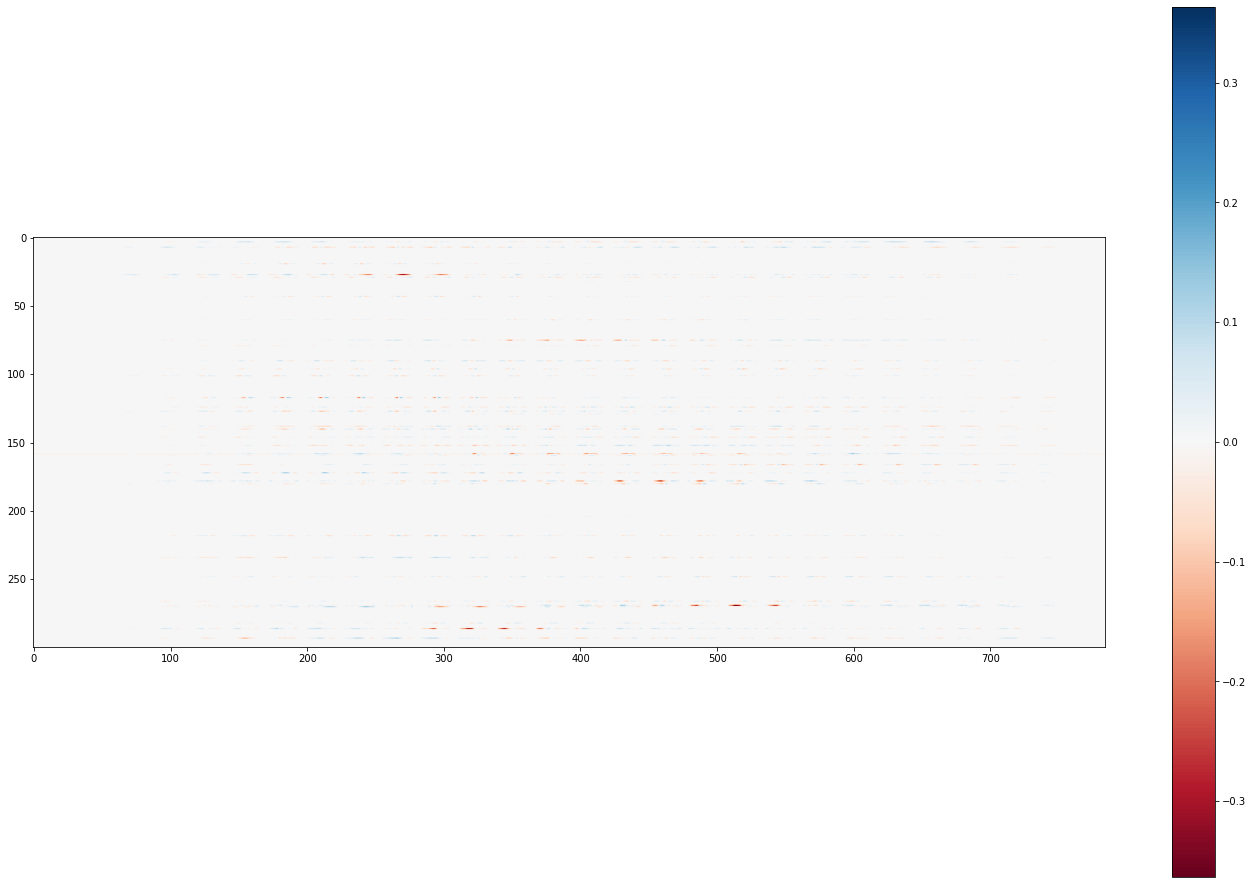

In [25]:
plot_weights(rd_model.fc1)

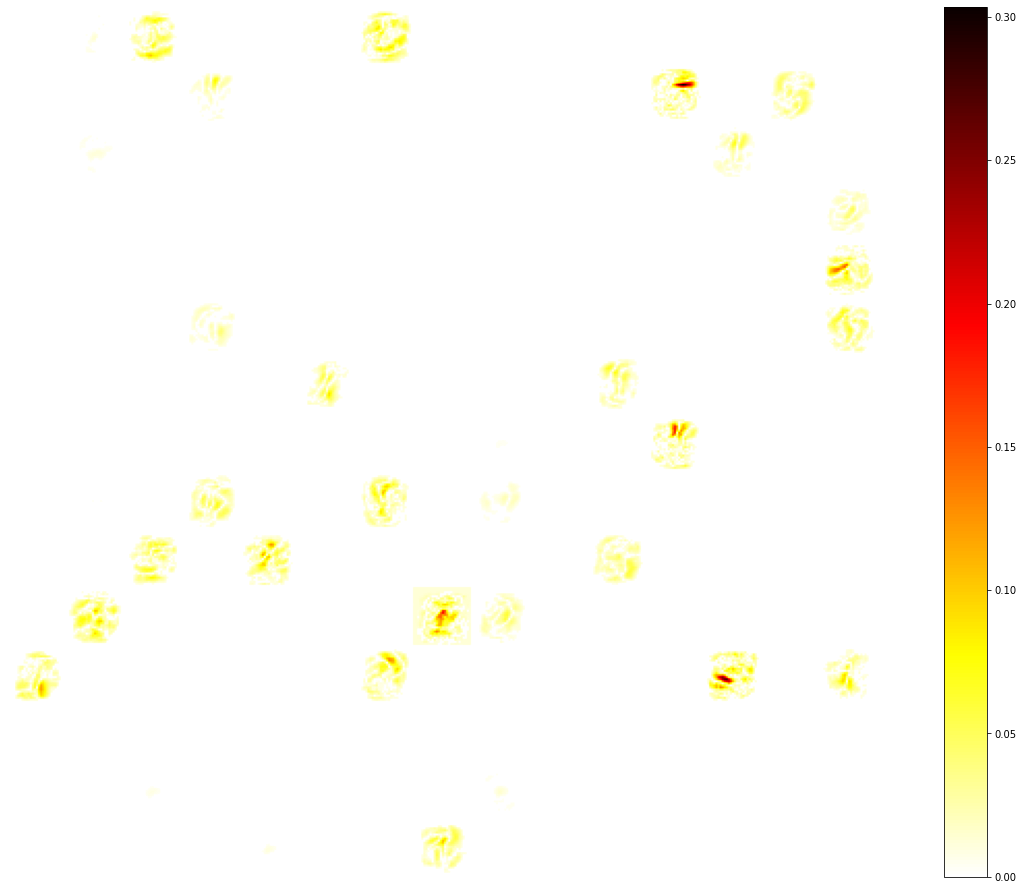

In [26]:
plot_neurons(rd_model.fc1)

In [27]:
def count_zero_rows(layer, threshold=None):
    threshold = threshold or layer.threshold
    zero_weights = (layer.log_alpha.detach().cpu().numpy() >= threshold)
    zero_rows = zero_weights.all(axis=1).sum()
    return zero_rows

In [28]:
print(f'Number of zero rows in original ARD model:\t{count_zero_rows(model.fc1)}')
print(f'Number of zero rows in Row Dropout ARD model:\t{count_zero_rows(rd_model.fc1)}')

Number of zero rows in original ARD model:	182
Number of zero rows in Row Dropout ARD model:	256


Well, this technique actually allows to zero out some rows of the weight matrix, but in terms of compression ratio and model's accuracy this is not the best solution.